<a href="https://colab.research.google.com/github/noemimanara/all-projects/blob/main/MAGIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries and reading data

First of all, we implement Python and the access to Google Drive (where whe have stored the dataset).

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Then we load the dataset, checking it is the correct one.

In [ ]:
# File ID of shared magic04.data
file_id = '1hgZuvPAmmiTRa8d77fi_8uCRVqWS52EJ'

downloaded = drive.CreateFile({'id': file_id}) #important
print(downloaded['title'])  # it should print the title of desired file
downloaded.GetContentFile('magic04.data')  

magic04.data


Some useful libraries are imported for the following analysis and data plots.

In [ ]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from matplotlib.patches import Ellipse, Circle
from matplotlib import animation
import seaborn as sns
import math
import pandas as pd
from IPython.display import display, HTML
from scipy import linalg as la
from scipy import integrate as intgr
import csv
from sklearn import preprocessing, ensemble, metrics, tree
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
import graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier, export_graphviz


from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show, reset_output
from bokeh.layouts import column, row, gridplot
from bokeh.models import CustomJS, Slider, ColumnDataSource, HoverTool, NormalHead, VeeHead, Label
from bokeh.models.widgets import Tabs, Panel
from bokeh.models.annotations import Span, Arrow
import bokeh.io
import bokeh.plotting
from bokeh.io import show
bokeh.io.output_notebook()

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#Color palette
BR41_DarkBlue = '#1C3455'
BR41_Blue = '#447B9C'
BR41_WhiteBlue= '#BFE4E1'
BR41_LightBlue = '#8BBCB4'
BR41_Red = '#E53944'
color_list = [BR41_DarkBlue, BR41_Blue, BR41_WhiteBlue, BR41_LightBlue,
              BR41_Red]

sns.set(
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'grid.color': 'gainsboro',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":12,
                                "axes.titlesize":16,
                                "axes.labelsize":14})

The data file is imported in the format of a Pandas Dataframe.

In [ ]:
names=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','category']

with open('magic04.data') as data_file:
  df=pd.read_csv(data_file, names=names)

ndf=df.to_numpy()

We print the data to get an overview of the content.

In [ ]:
df

fLength    fWidth   fSize   fConc  ...  fM3Trans   fAlpha     fDist  category
0       28.7967   16.0021  2.6449  0.3918  ...   -8.2027  40.0920   81.8828         g
1       31.6036   11.7235  2.5185  0.5303  ...   -9.9574   6.3609  205.2610         g
2      162.0520  136.0310  4.0612  0.0374  ...  -45.2160  76.9600  256.7880         g
3       23.8172    9.5728  2.3385  0.6147  ...   -7.1513  10.4490  116.7370         g
4       75.1362   30.9205  3.1611  0.3168  ...   21.8393   4.6480  356.4620         g
...         ...       ...     ...     ...  ...       ...      ...       ...       ...
19015   21.3846   10.9170  2.6161  0.5857  ...    2.8766   2.4229  106.8258         h
19016   28.9452    6.7020  2.2672  0.5351  ...   -2.9632  86.7975  247.4560         h
19017   75.4455   47.5305  3.4483  0.1417  ...   -9.4662  30.2987  256.5166         h
19018  120.5135   76.9018  3.9939  0.0944  ...  -63.8389  84.6874  408.3166         h
19019  187.1814   53.0014  3.2093  0.2876  ...   31.4755  52.7310  272.3174         h

[19020 rows x 11 columns]

# Data Visualization

In order to give a simple hunch of the physical meaning of the features, here we show some random data as the ellipse in the telescope plane as reconstructed with the variables: length, width, dist and alpha.

In [ ]:
def dg_conv(ang,x,y):
  supp_ang=np.arccos(x/np.sqrt(x**2+y**2))
  if y<0:
    supp_ang=2*np.pi-supp_ang
  return (supp_ang)-((np.pi)/180*ang)+ np.pi/2

def col_choose(tip):
  if tip=='g':
    c=BR41_Red
  elif tip=='h':
    c=BR41_DarkBlue
  return c

def lab_choose(tip):
  if tip=='g':
    lab="Gamma"
  elif tip=='h':
    lab="Hadron"
  return lab

plot = figure(plot_width=600, plot_height=600, x_range=[-550,550], y_range=[-550,550],
             x_axis_label='x [mm]',
             x_axis_location='below',
             x_axis_type='linear',
             y_axis_label='y [mm]',
             y_axis_location='left',
             y_axis_type='linear')
plot.axis.axis_line_color = "gray"

indexes=np.random.randint(0,df.shape[0],size=50)

plot.circle(x=0, y=0, radius=500, fill_color=BR41_WhiteBlue, legend_label="Telescope")
plot.cross(x=0, y=0, size=10, fill_color='black', line_color='black')

for i in indexes:
  dato=df.iloc[i]
  d=dato['fDist']
  angolo=np.random.random(1)*2*np.pi
  x_c=d*np.cos(angolo)
  y_c=d*np.sin(angolo)
  plot.ellipse(x=x_c, y=y_c, width=dato['fWidth'], height=dato['fLength'], fill_color=col_choose(dato['category']), angle=dg_conv(dato['fAlpha'],x_c,y_c), line_color=None, legend_label=lab_choose(dato['category']))

plot.legend.label_text_font = "calibri"
plot.legend.label_text_font_size='12px'
plot.legend.margin = 4
show(plot)

# Study of the features of the datasets, comparison  between signal and background events

First of all, we compute the statistical variables (mean, standard deviation, maximum, minimum) and display an histogram for each feature of the data, distinguishing between signal and background.

In [ ]:
sign_descr, bkg_descr=df[df['category']=='g'].describe().T[['mean','std','max','min']],df[df['category']=='h'].describe().T[['mean','std','max','min']]
sign_descr=sign_descr.round(2)

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.format("{:.2f}").set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))
    
display_side_by_side([sign_descr, bkg_descr], ['SIGNALS', 'BACKGROUND'])



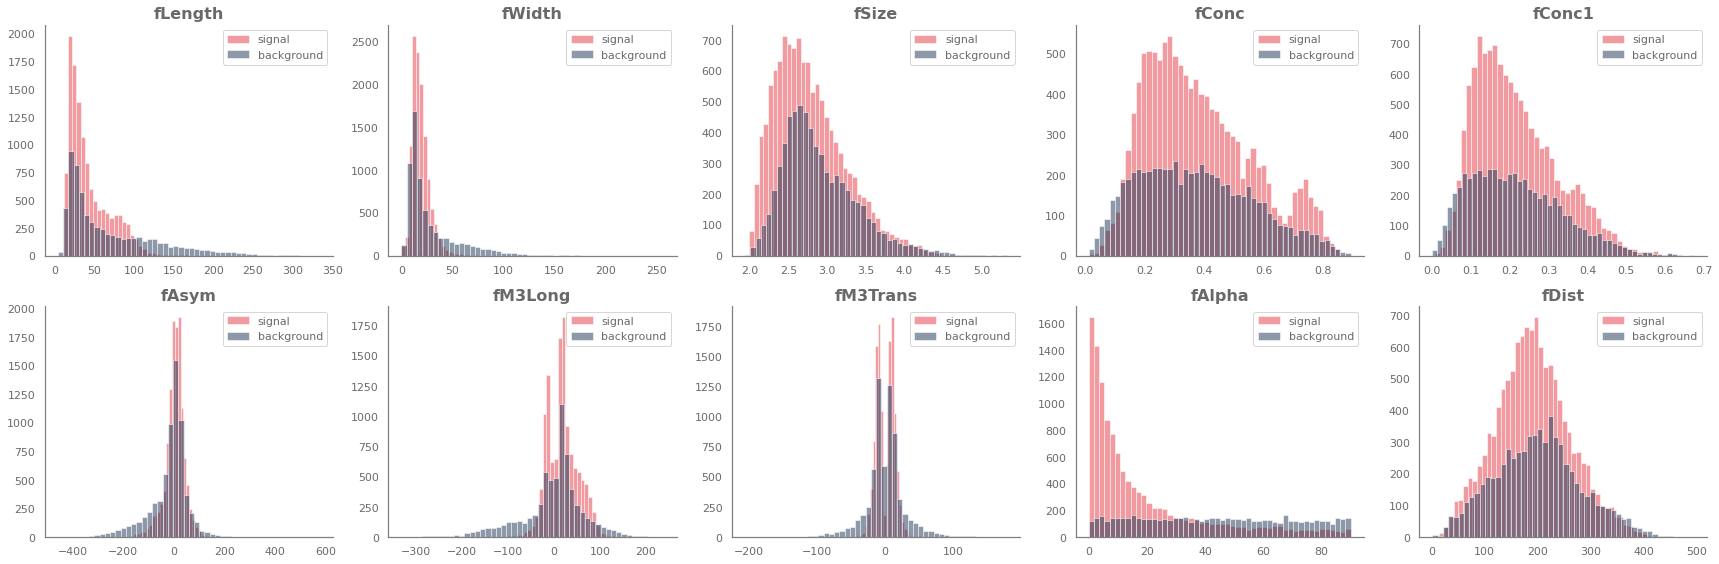

In [ ]:
def plothisto(ax_list, df, names):
  k, l, i, j = 0, 0, 0, 0
  for i in range (0,10,1):
    gr = ax_list[k][l].hist(df[df['category']=='g'][names[i]].values,50, color=BR41_Red, label='signal', alpha=0.5) 
    gr = ax_list[k][l].hist(df[df['category']=='h'][names[i]].values,50, color=BR41_DarkBlue, label='background', alpha=0.5)   
    ax_list[k][l].legend(loc='best')
    ax_list[k][l].set_title(names[i], fontweight='bold')
    l += 1
    if l==5:
      l = 0
      k += 1

figure_dat, ax_dat = plt.subplots(nrows=2, ncols=5, figsize=(24,8))
names95 = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist']
plothisto(ax_dat, df, names95)
figure_dat.tight_layout()
figure_dat.show()

From the previous graphs it's possible to notice that the largest differences between the distributions of the data features concern the parameter Alpha. For the signals we have a distribution that, starting form zero, decreases exponentially, while for background events the distributions appers more similar to a uniform one.
Some noticeble differences appear also for fLength and fWidth, where the distributions for the hadrons has a thicker tail than the signal's one.

# Correlation among the features

We proceed with the computation of the correlation matrices of the features for both signal and background. We choose to display the signal one, and the one obtained as the difference of the two matrices (signal - background), to enhance the visualization of the differences. "Hot-cold" palettes are used for an easier understanding at a glance of the matrices.

The method used is Pearson's:

$\rho_{X,Y}=\frac{Cov(X,Y)}{\sqrt{Var(X)Var(Y)}}= \frac{\sum^N_{i=1}{(x_i-\bar{x})(y_i-\bar{y})}}{\sqrt{\sum^N_{i=1}{(x_i-\bar{x})^2}\sum^N_{i=1}{(y_i-\bar{y})^2}}}$

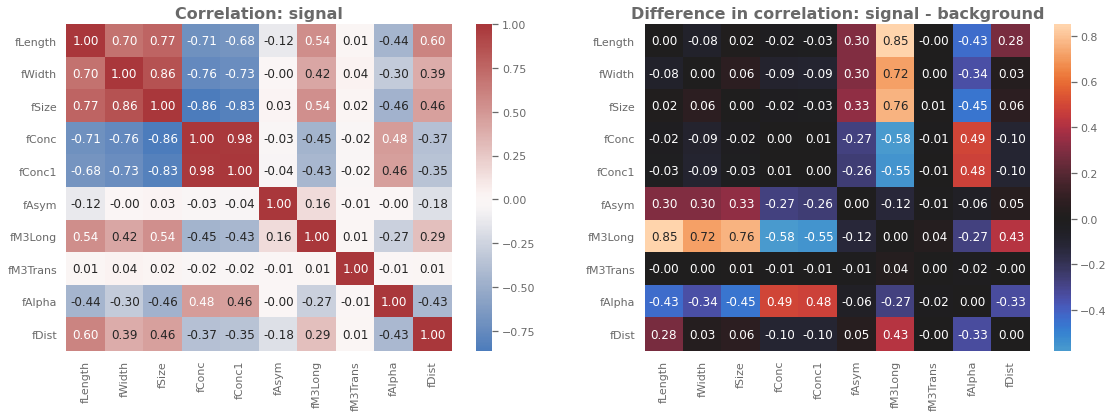

In [ ]:
#correlation matrices with Pandas dataframe
sgn_corr, bkg_corr = df[df['category']=='g'].corr(), df[df['category']=='h'].corr()

#plots
f_corr, (ax_sgn_corr, ax_bkg_corr) = plt.subplots(nrows=1, ncols=2, figsize=(19, 6))
ax_sgn_corr.set_title('Correlation: signal', fontweight="bold")
tabc_sgn = sns.heatmap(sgn_corr, center=0, cmap='vlag', annot=True, fmt='.2f', linewidths=0,
            xticklabels=sgn_corr.columns.values,
            yticklabels=sgn_corr.columns.values, ax=ax_sgn_corr)
ax_bkg_corr.set_title('Difference in correlation: signal - background', fontweight="bold")
tabc_corr = sns.heatmap(sgn_corr-bkg_corr, center=0, cmap='icefire', annot=True, fmt='.2f', linewidths=0,
            xticklabels=bkg_corr.columns.values,
            yticklabels=bkg_corr.columns.values, ax=ax_bkg_corr)
f_corr.show()

Features display both behaviours of correlation (red) and anticorrelation (blue). \\
Let's take a closer look. \\
The pattern for the first 5 features is the same for both signal and background: those features are strongly correlated (4th and 5th anticorrelated) between themselves. \\
Also the 7th, 9th and 10th features show appreciable correlations with the first five. These are also the features, along with fAsym, that change the most in behaviour when we consider the background. \\
The features that for signal data do not display appreciable correlation and could thus be considered linearly independent are fAsym and fM3Trans; the last one has approximately the same behaviour for background data, so apparently it is a linearly indipendent variable in every case. \\

- _Strongest correlation in signal_:
 0.979 between fConc and fConc1

 > This is due to the similar definition of these features: they differ just for an additive quantity


- _Strongest anticorrelation in signal_: 
 -0.863 between fConc and fSize

 > The reason of this strong beahaviour lies in the definition of these variables: fConc is the ratio of sum of two highest pixels over fSize. For a fact, the same behaviour is displayed also by the variable fConc1, which has a definition (ratio of highest pixel over fSize) very similar to the one of fConc.

Looking at the differences between signal correlation and background correlation, we see that the ones that differ the most are fAsym, fM3Long and fAlpha. That is because of the different dimensionality of background and signal events: the former are more uniform, the latter more elongated. The difference in fAlpha is explained by the fact that background arrives from random directions, while signal only from the source that is being observed.

What is left to explain is the apparently identical behaviour of Width, Length and Size for signal and background.


To better understand why some features that are correlated for signal show the opposite behaviour for the background, we plot each feature versus each other, showing in red the signal and in blue the background.

<Figure size 432x288 with 0 Axes>

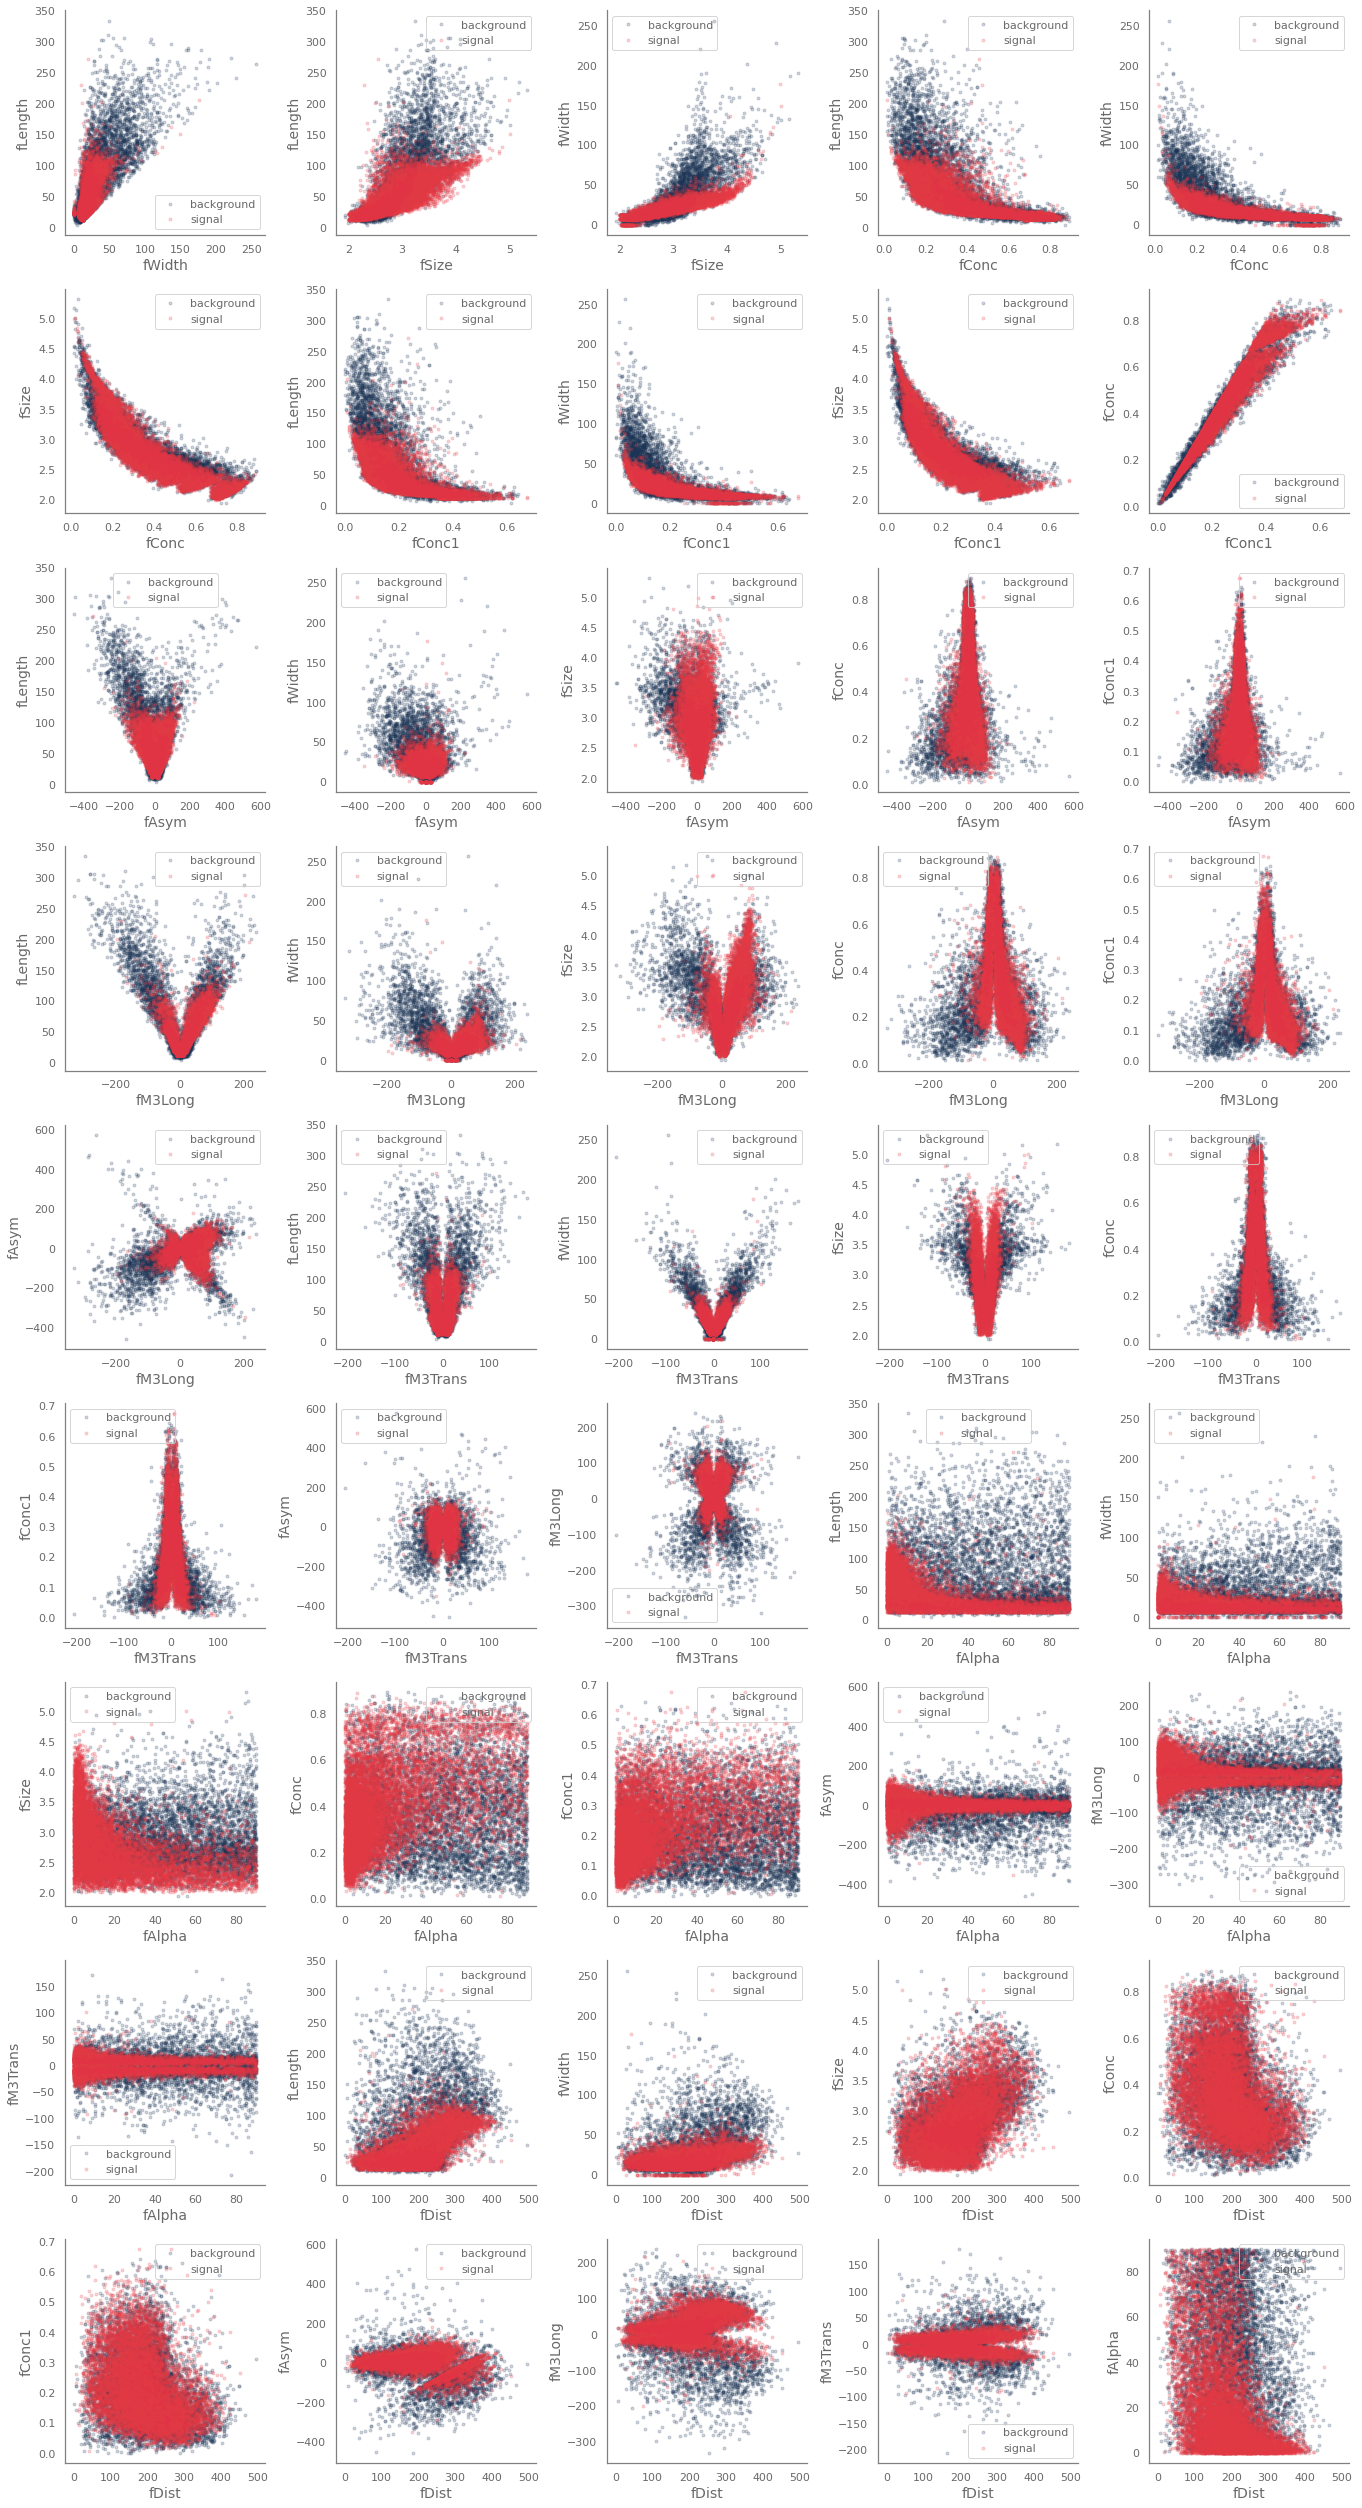

In [ ]:
plt.subplots_adjust(hspace=0.5)
def plot1vs2(ax_list, df, names):
  k, l, i, j = 0, 0, 0, 0
  for i in range (0,10,1):
    for j in range (0,10,1):
      if j<i:
        gr = ax_list[k][l].plot(df[df['category']=='h'][names[i]],df[df['category']=='h'][names[j]], '.', color=BR41_DarkBlue, alpha=0.2, label='background')
        gr = ax_list[k][l].plot(df[df['category']=='g'][names[i]],df[df['category']=='g'][names[j]], '.', color=BR41_Red, alpha=0.2, label='signal')
        ax_list[k][l].set_ylabel(names[j])
        ax_list[k][l].set_xlabel(names[i])
        ax_list[k][l].legend(loc='best')
        l += 1
        if l==5:
          l = 0
          k += 1
      
fig_corr95, ax95 = plt.subplots(nrows=9, ncols=5, figsize=(19, 35))

plot1vs2(ax95, df, names95)
plt.tight_layout()
plt.show()

As it is possible to see, only a few features display a relation that can be approximated linearly: (fConc, fConc1), (fAsym, fAlpha), (fM3Long, fAlpha), (fM3Trans, fAlpha). All the others have non-linear peculiar relations. What determines the different correlations is a wider range populated by the background, sometimes asymmetrically, as in the case (fM3Long, fSize), where the difference in correlation between signal and background is one of the highest: 0.765.

From these graphs it is possible to guess that cuts on the features can be a level zero approach, without the implication of machine learning strategies, to this problem, as done with fLenght, fSize and fWidth in [1].

# Rescaling and comparison for high and low light

To investigate deeper the behaviour for signal and background for the features of fLength and fWidth, we rescale them according to *standardization*:

$f' = \frac{f-\mu_f}{\sigma_f}$

Afterwards we select low light and high light events to compare. We do so by exploiting the variable fSize, which is the logarithm of the number of photoelectrons registered by the telescope. We arbitrarily label as "dark events" the ones with fSize < 3, and as "bright events" the ones with fSize > 4.

In [ ]:
#Rescaling
signal=df[df['category']=='g'].drop(columns='category')
background=df[df['category']=='h'].drop(columns='category')

lw_sgn=signal.copy()
lw_sgn['fLength']=(signal['fLength']-signal['fLength'].mean())/signal['fLength'].std()
lw_sgn['fWidth']=(lw_sgn['fWidth']-lw_sgn['fWidth'].mean())/lw_sgn['fWidth'].std()

lw_bkg=background.copy()
lw_bkg['fLength']=(lw_bkg['fLength']-lw_bkg['fLength'].mean())/lw_bkg['fLength'].std()
lw_bkg['fWidth']=(lw_bkg['fWidth']-lw_bkg['fWidth'].mean())/lw_bkg['fWidth'].std()

#Splitting high ligth and low ligth
max_size_sgn, min_size_sgn=signal['fSize'].max(), signal['fSize'].min()
max_size_bkg, min_size_bkg=background['fSize'].max(), background['fSize'].min()
size_range_sgn, size_range_bkg= max_size_sgn-min_size_sgn, max_size_bkg-min_size_bkg
percentage=0.2

max_threshold=4
min_threshold=3

resc_sgn_max = lw_sgn[lw_sgn['fSize']>max_threshold]
resc_sgn_min = lw_sgn[lw_sgn['fSize']<min_threshold]

resc_bkg_max = lw_bkg[lw_bkg['fSize']>max_threshold]
resc_bkg_min = lw_bkg[lw_bkg['fSize']<min_threshold]

resc_sgn = lw_sgn[(lw_sgn['fSize'] >= min_threshold) & (lw_sgn['fSize'] <= max_threshold)]
resc_bkg = lw_bkg[(lw_bkg['fSize'] >= min_threshold) & (lw_bkg['fSize'] <= max_threshold)]

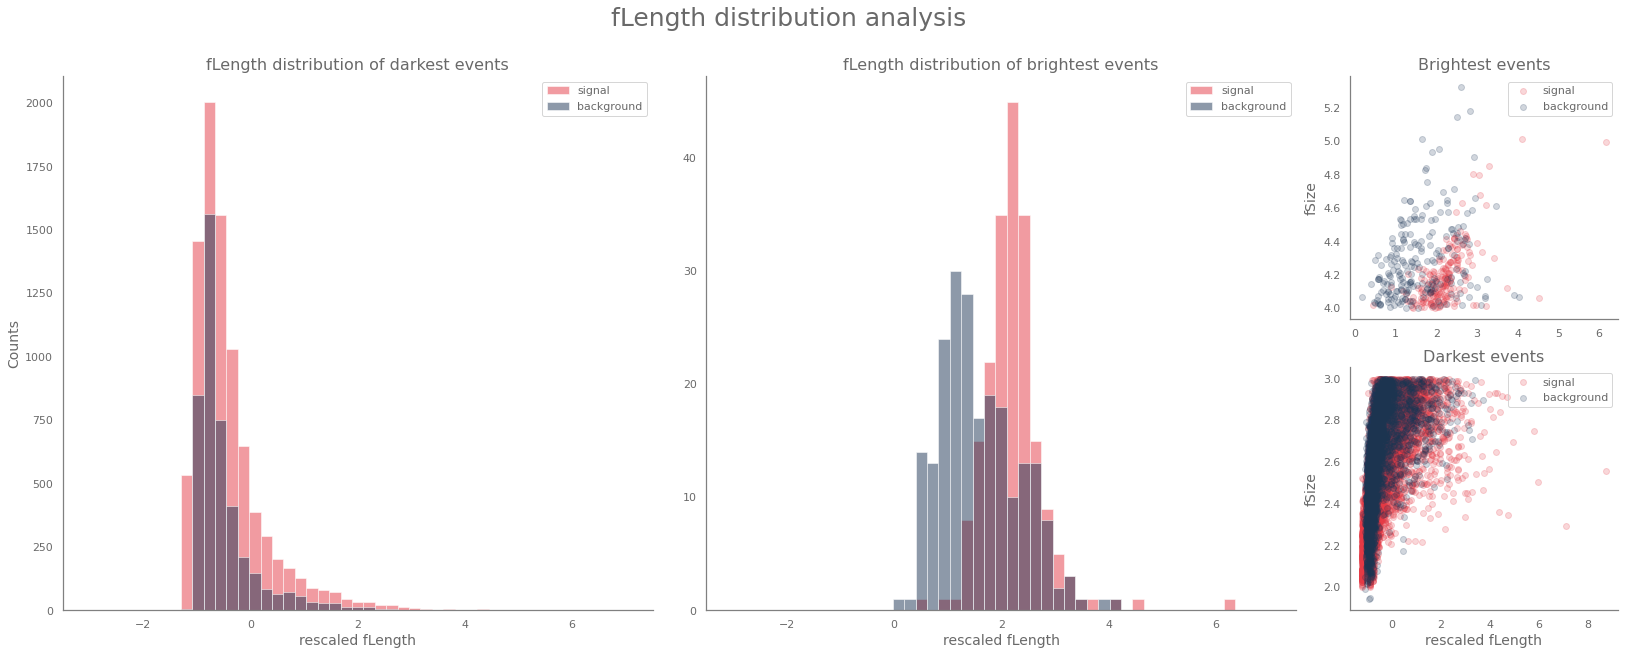

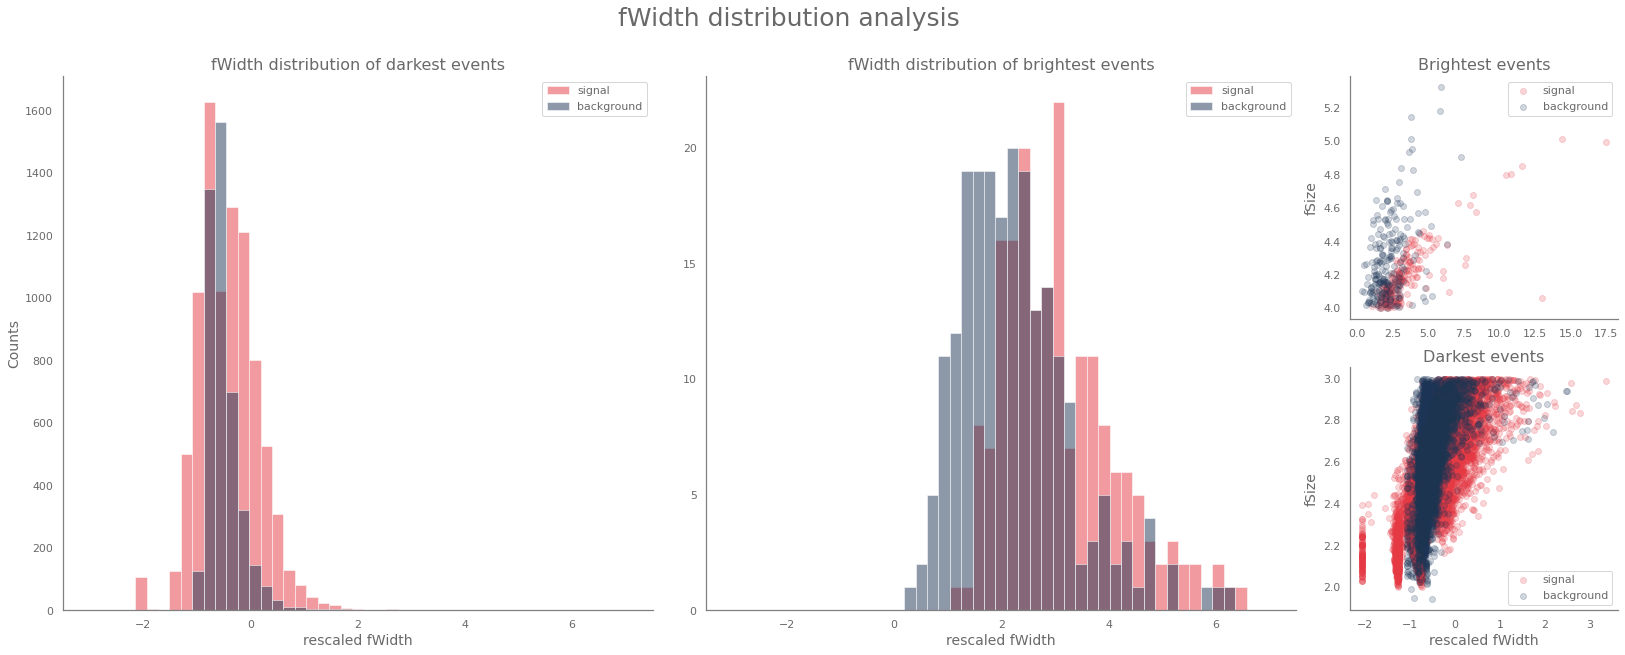

In [ ]:
gridsize=(5,5)
f_figure=plt.figure(figsize=(24,24))
f_figure.suptitle('fLength distribution analysis',fontsize=25,x=0.42)
f_figure.subplots_adjust(top=0.94,left=0)

histo1=plt.subplot2grid(gridsize,loc=(0,0),rowspan=2,colspan=2)
histo1.hist(np.array(resc_sgn_min)[:,0],bins=np.linspace(-3,7,48),color=BR41_Red,label='signal',alpha=0.5)
histo1.hist(np.array(resc_bkg_min)[:,0],bins=np.linspace(-3,7,48),color=BR41_DarkBlue,label='background',alpha=0.5)
histo1.legend(loc='best')
histo1.set_title('fLength distribution of darkest events')
histo1.set_ylabel('Counts')
histo1.set_xlabel('rescaled fLength')

histo2=plt.subplot2grid(gridsize,loc=(0,2),rowspan=2,colspan=2)
histo2.hist(np.array(resc_sgn_max)[:,0],bins=np.linspace(-3,7,48),color=BR41_Red,label='signal',alpha=0.5)
histo2.hist(np.array(resc_bkg_max)[:,0],bins=np.linspace(-3,7,48),color=BR41_DarkBlue,label='background',alpha=0.5)
histo2.legend(loc='best')
histo2.set_title('fLength distribution of brightest events')
histo2.set_xlabel('rescaled fLength')

array0=plt.subplot2grid(gridsize,loc=(0,4),rowspan=1,colspan=1)
array0.scatter(np.array(resc_sgn_max)[:,0],np.array(resc_sgn_max)[:,2],color=BR41_Red,label='signal',alpha=0.2)
array0.scatter(np.array(resc_bkg_max)[:,0],np.array(resc_bkg_max)[:,2],color=BR41_DarkBlue,label='background',alpha=0.2)
array0.set_ylabel('fSize')
array0.legend(loc = 'best')
array0.set_title('Brightest events')


array1=plt.subplot2grid(gridsize,loc=(1,4),rowspan=1,colspan=1)
array1.scatter(np.array(resc_sgn_min)[:,0],np.array(resc_sgn_min)[:,2],color=BR41_Red,label='signal',alpha=0.2)
array1.scatter(np.array(resc_bkg_min)[:,0],np.array(resc_bkg_min)[:,2],color=BR41_DarkBlue,label='background',alpha=0.2)
array1.set_xlabel('rescaled fLength')
array1.set_ylabel('fSize')
array1.legend(loc = 'best')
array1.set_title('Darkest events')

plt.show()

gridsize=(5,5)
s_figure=plt.figure(figsize=(24,24))
s_figure.suptitle('fWidth distribution analysis',fontsize=25,x=0.42)
s_figure.subplots_adjust(top=0.94,left=0)

histo3=plt.subplot2grid(gridsize,loc=(0,0),rowspan=2,colspan=2)
histo3.hist(np.array(resc_sgn_min)[:,1],bins=np.linspace(-3,7,48),color=BR41_Red,label='signal',alpha=0.5)
histo3.hist(np.array(resc_bkg_min)[:,1],bins=np.linspace(-3,7,48),color=BR41_DarkBlue,label='background',alpha=0.5)
histo3.legend(loc='best')
histo3.set_title('fWidth distribution of darkest events')
histo3.set_ylabel('Counts')
histo3.set_xlabel('rescaled fWidth')

histo4=plt.subplot2grid(gridsize,loc=(0,2),rowspan=2,colspan=2)
histo4.hist(np.array(resc_sgn_max)[:,1],bins=np.linspace(-3,7,48),color=BR41_Red,label='signal',alpha=0.5)
histo4.hist(np.array(resc_bkg_max)[:,1],bins=np.linspace(-3,7,48),color=BR41_DarkBlue,label='background',alpha=0.5)
histo4.legend(loc='best')
histo4.set_title('fWidth distribution of brightest events')
histo4.set_xlabel('rescaled fWidth')

array2=plt.subplot2grid(gridsize,loc=(0,4),rowspan=1,colspan=1)
array2.scatter(np.array(resc_sgn_max)[:,1],np.array(resc_sgn_max)[:,2],color=BR41_Red,label='signal',alpha=0.2)
array2.scatter(np.array(resc_bkg_max)[:,1],np.array(resc_bkg_max)[:,2],color=BR41_DarkBlue,label='background',alpha=0.2)
array2.set_ylabel('fSize')
array2.legend(loc = 'best')
array2.set_title('Brightest events')

array3=plt.subplot2grid(gridsize,loc=(1,4),rowspan=1,colspan=1)
array3.scatter(np.array(resc_sgn_min)[:,1],np.array(resc_sgn_min)[:,2],color=BR41_Red,label='signal',alpha=0.2)
array3.scatter(np.array(resc_bkg_min)[:,1],np.array(resc_bkg_min)[:,2],color=BR41_DarkBlue,label='background',alpha=0.2)
array3.set_ylabel('fSize')
array3.set_xlabel('rescaled fWidth')
array3.legend(loc = 'best')
array3.set_title('Darkest events')

plt.show()

Both rescaled fLength and fWidth display overlapping of the signal and background distribution for low ligth evens, whilst for bright events it is possible to approximately separate background and signal with the means of a linear cut. That is, for events for which there is more information, it is possible to classify them with simply by their fLength and fWidth values.


This can be also seen in the correlation matrices showed below: when considering only brigth events with fLength and fWidth rescaled, there appear non zero differences in correlations for these three main variables.

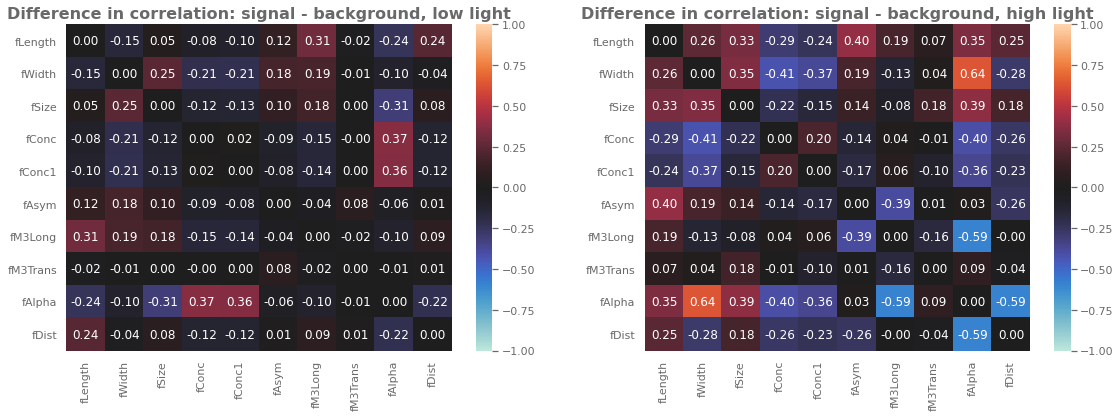

In [ ]:
sgn_min_resc_corr, bkg_min_resc_corr = resc_sgn_min.corr(), resc_bkg_min.corr()
sgn_max_resc_corr, bkg_max_resc_corr = resc_sgn_max.corr(), resc_bkg_max.corr()

f_corr_resc, (ax_min_corr, ax_max_corr) = plt.subplots(nrows=1, ncols=2, figsize=(19, 6))
ax_min_corr.set_title('Difference in correlation: signal - background, low light', fontweight="bold")
tabc_min = sns.heatmap(sgn_min_resc_corr-bkg_min_resc_corr, vmin=-1, vmax=1, center=0, cmap='icefire', annot=True, fmt='.2f', linewidths=0,
            xticklabels=bkg_min_resc_corr.columns.values,
            yticklabels=bkg_min_resc_corr.columns.values, ax=ax_min_corr)
ax_max_corr.set_title('Difference in correlation: signal - background, high light', fontweight="bold")
tabc_max = sns.heatmap(sgn_max_resc_corr-bkg_max_resc_corr, vmin=-1, vmax=1, center=0, cmap='icefire', annot=True, fmt='.2f', linewidths=0,
            xticklabels=bkg_max_resc_corr.columns.values,
            yticklabels=bkg_max_resc_corr.columns.values, ax=ax_max_corr)
f_corr_resc.show()


# PCA

First of all, we prepare the data, dropping the "category" column, then we rescale all the data as
$f' = \frac{f-\mu_f}{\sigma_f}$ so that we don't have issues with the different ranges of magnitude of the features.

In [ ]:
#PCA
df1=df.drop(columns='category')#removing the last column
df_norm=(df1-df1.mean(axis=0))/df.std(axis=0)
df_norm=df_norm.T

We are ready to compute the characteristic variables of the principal component analysis (eigenvalues, transform and antitransform matrix) exploiting the scipy optimized routine. We then display the eigenvalues and corresponding eigenvectors of the normalized data matrix.

In [ ]:
V_svd,s,V_t=la.svd(df_norm)
l_svd=(s**2)/(df_norm.shape[1]-1)

print('Eigenvalues:\n',l_svd,'\n')
print('Associated ratio of the total dataset variability:\n', l_svd/np.sum(l_svd), '\n')
print('Matrix of principal components:')
V_svd=pd.DataFrame(V_svd)
V_svd.columns=['v{}'.format(i) for i in range (10)]
V_svd

Eigenvalues:
 [4.2239909  1.5751879  1.01180532 0.9940127  0.74201939 0.65008647
 0.4075386  0.22036243 0.15475338 0.02024291] 

Associated ratio of the total dataset variability:
 [0.42239909 0.15751879 0.10118053 0.09940127 0.07420194 0.06500865
 0.04075386 0.02203624 0.01547534 0.00202429] 

Matrix of principal components:


v0        v1        v2  ...        v7        v8        v9
0 -0.408277  0.225699 -0.000501  ...  0.753225 -0.090466 -0.017996
1 -0.395057  0.245282 -0.152718  ... -0.539479  0.427867  0.011798
2 -0.448922 -0.093311 -0.070601  ... -0.321599 -0.815749 -0.107612
3  0.441612  0.188376  0.128920  ... -0.071913 -0.148747 -0.748912
4  0.429238  0.195952  0.139198  ... -0.105167 -0.315173  0.653467
5  0.144688 -0.486903 -0.377273  ...  0.139312 -0.006971  0.000101
6 -0.005198 -0.599591 -0.058326  ... -0.035734  0.091119 -0.002716
7 -0.012352  0.031477 -0.602870  ...  0.017257 -0.009226  0.000009
8  0.097175  0.456704 -0.469919  ...  0.026551 -0.039371  0.005783
9 -0.256681 -0.012468  0.453523  ... -0.016429  0.108867  0.005261

[10 rows x 10 columns]

Then we perform a PCA to hold at least 90% of the total dataset variability. Only in this way we have a significant reduction of the dimensionality of the dataset: almost all the features retain at least 1% of the total dataset variability.

In [ ]:
def PCA(l_svd,V_svd,threshold):
    variability=0.
    count=0
    
    while variability<threshold:
        variability+=l_svd[count]/np.sum(l_svd)
        count+=1
    print('The {:.2f}% of the system variability is explained by the first {} principal components.\n' .format(variability*100,count))
    dfp=np.dot(V_svd.T,df_norm)
    df_reduced=dfp[0:count,:]
    return dfp,df_reduced

dfp,df_reduced=PCA(l_svd,V_svd,threshold=0.90)
df_reduced=pd.DataFrame(df_reduced.T)
df_reduced.columns=['x{}'.format(i) for i in range (df_reduced.shape[1])]
df_reduced

The 91.97% of the system variability is explained by the first 6 principal components.



x0        x1        x2        x3        x4        x5
0      1.016523 -0.369247 -0.809929 -1.121598 -0.524969  0.465095
1      1.679917 -0.549211  0.981589  0.221176  0.137608 -0.487986
2     -5.966085  1.831268 -1.497166 -3.728859  0.487616 -3.418884
3      2.556993 -0.031628  0.441375 -0.031437 -0.676063 -0.251752
4     -1.655809 -0.552887  0.555498  1.771565  0.870944 -0.803792
...         ...       ...       ...       ...       ...       ...
19015  2.189588 -0.346005  0.219445  0.390771 -0.706915  0.130934
19016  1.857696  0.695700 -0.511349 -0.567833  1.714817 -0.783631
19017 -2.763882 -0.491173 -0.062801 -0.648306  0.477706 -0.048802
19018 -4.647063  2.310498  1.167479 -2.960968  1.241773 -2.826351
19019 -3.354211  4.764197 -0.093265  1.574319 -0.690294 -0.258108

[19020 rows x 6 columns]

This algorithm allows to work with just 6 new features (linear combinations of previous features) versus the original 10, still this costs more than 8% of the total varibility of the dataset. Since the computational resources at our disposal allow us to work with the whole dataset, we keep all of the data for the next steps of the analysis.


# Multivariate analysis: Random Forest

The discrimination between an event related to hadron showers and one related to gamma rays is performed using a technique based on Random Forest, which is an ensamble of Decision Trees. A Decision Tree is a predictive model capable to perform multi-class classification on a dataset by applying cuts on the features and splitting the data in each node in two branches based on these cuts. Each node of the tree represents a cut on a feature and the final nodes (the leaves) give each sample its label. A node becomes a leaf when all the data that it contains belong to a single class or when the a priori fixed maximum depth of the tree is reached. A Random Forest combines the results of several decision trees and assigns to an event the label that is predicted most frequently. Each tree of a RF is trained using a random subset of samples (n_samp) of the trainig set in order to avoid overfitting and each one uses a random subset of features for nodes' division.








The implementation of a RF is very useful because it allows us to take in account all the features and their correlations simultanously. An anlysis with RF is performed on the renormalized data using all parmeters except fAlpha, which is the most discriminating one and that will be used later. In order to do this the dataset and the real labels are splitted into a training set (1/3 of the total) used to construct the RF, a validation set (1/3) used to optimize some other cuts, and a test set (1/3) on which the analysis is performed.


In [ ]:
ndf[:][ndf=='g']=1
ndf[:][ndf=='h']=0

X=np.array(ndf[:,[0,1,2,3,4,5,6,7,8,9]]).astype(np.float32)
Y=np.array(ndf[:,-1:].flatten()).astype(np.float32)

#standardization
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

#shuffle data
np.random.seed(1145215)
permutation = np.random.permutation(X.shape[0])

X_scaled = X_scaled[permutation]
X = X [permutation]
Y = Y[permutation]

#split data in training set (1/3), validation set (1/3) and test set (1/3)
m_size=int (X_scaled.shape[0]*1/3)

X_train, X_valid, X_test = X_scaled[:m_size,[0,1,2,3,4,5,6,7,9]], X_scaled[m_size:m_size*2,[0,1,2,3,4,5,6,7,9]], X_scaled[m_size*2:,[0,1,2,3,4,5,6,7,9]]
X_alpha_train, X_alpha_valid, X_alpha_test= X[:m_size,8], X[m_size:m_size*2, 8], X[m_size*2:, 8]
Y_train, Y_valid, Y_test = Y[:m_size], Y[m_size:m_size*2], Y[m_size*2:]

#Check that every set is heterogeneous
print(np.array(Y_train).mean(), np.array(Y_valid).mean(), np.array(Y_test).mean())

0.6484227 0.6522082 0.6444795


In the figure below we can observe an example fo Decision Tree constructed with low depth in order to be visible. The choice of the feature to be splitted is made by looking at the Gini coefficient defined as $G(i)=1-\sum_{j=1}^m f(i,j)^2$ where $f(i,j)$ is the frequency of the class $j$ when we restrict the data to the $i$-th cathegory. It's chosen the feature $i$ and a corrisponding cut that has minimum Gini coefficient. When $G(i)=0$ the node contains samples that belong to a single class and it becomes a leaf. If we reach the maximum depth but $G(i)\neq 0$ it is assigned the label of the most frequent class in the node. 

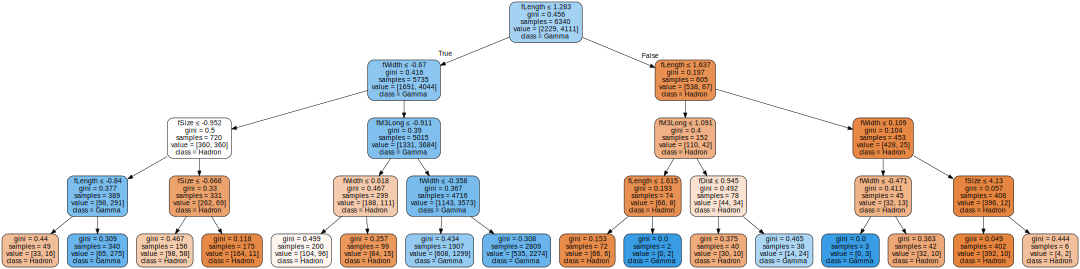

In [ ]:
ex_tree=tree.DecisionTreeClassifier(max_depth=4)
ex_tree=ex_tree.fit(X_train, Y_train)

feat_names=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fDist']
dot_data = tree.export_graphviz(ex_tree, out_file=None, 
                      feature_names=feat_names,  
                      class_names=['Hadron', 'Gamma'],  
                      filled=True, rounded=True,  
                      special_characters=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"15,8!"')
graph = graphviz.Source(pydot_graph.to_string())  
graph 

The most important parametres of a RF are the number of trees (n_estimators), the maximum depth of each tree (max_depth) and the number of sample used to train each tree (n_samp) that for our analisys is set to be the 2/3 of the number of sample in the training set. 

To find the combination of these hyperparameters that maximize the performances, we construct (using the training set) several RF varying them, apply the RF to the validation set, draw a ROC curve (which properties will be described in the next paragraph) and evaluate the area under it (auc). The parameters related to the maximum auc are chosen for the further analisys.


In [ ]:
max_depth_list=np.arange(1,50,2)
n_estimators_list=np.arange(1,40,2)
n_samp=int(X_train.shape[0]*2/3)
auc_list, param_list=[],[]

# vary hyperparametres and compute auc
for md, ne in ((md,ne) for md in max_depth_list for ne in n_estimators_list):
  forest=ensemble.RandomForestClassifier(n_estimators=ne, max_depth=md, max_samples=n_samp)
  forest.fit(X_train,Y_train)
  gammaness=forest.predict_proba(X_valid)[:,1]
  auc_list.append(metrics.roc_auc_score(Y_valid, gammaness))
  param_list.append([md,ne])


Max AUC: 0.87
Maximum tree depth:  37 
Number of trees:  39


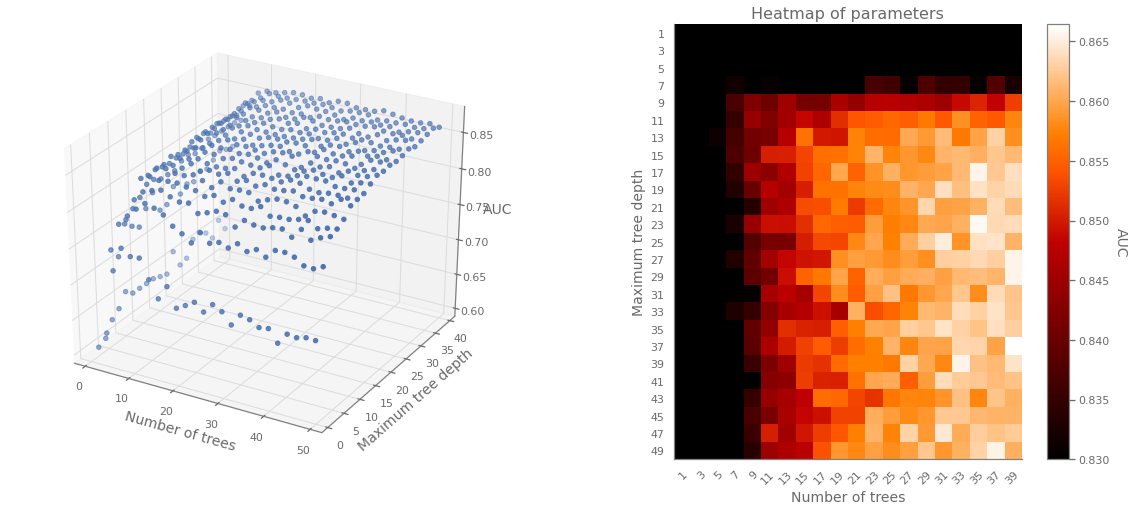

In [ ]:
# find the maximum value of auc and the corrispondig parameters
max_auc, auc_index=auc_list[0],0
for i in range(len(auc_list)):
  if auc_list[i]>max_auc:
    max_auc=auc_list[i]
    auc_index=i

param_list=np.array(param_list)
print('Max AUC: {:.2f}'.format(max_auc))
print("Maximum tree depth: ", param_list[auc_index][0], "\nNumber of trees: ",param_list[auc_index][1])

#Scatterplot
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter3D(param_list[:,0],param_list[:,1],auc_list)
ax.set_xlabel("Number of trees")
ax.set_ylabel("Maximum tree depth")
ax.set_zlabel("AUC")

#Heatmap
npauc = np.array(auc_list)
npr_auc =npauc.reshape(len(max_depth_list),len(n_estimators_list))
axAUC = fig.add_subplot(1, 2, 2)
imAUC = axAUC.imshow(npr_auc, vmin=0.83, cmap='gist_heat')
cbar = axAUC.figure.colorbar(imAUC, ax=axAUC, cmap='Reds')
cbar.ax.set_ylabel("AUC", rotation=-90, va="bottom")

# Fix ticks
axAUC.set_xticks(np.arange(len(n_estimators_list)))
axAUC.set_yticks(np.arange(len(max_depth_list)))
axAUC.set_xticklabels(n_estimators_list)
axAUC.set_yticklabels(max_depth_list)
plt.setp(axAUC.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

axAUC.set_title("Heatmap of parameters")
axAUC.set_xlabel("Number of trees")
axAUC.set_ylabel("Maximum tree depth")

plt.show()

A ROC curve represents the relationship between the True Positive Rate (TPR) and the False Positive Rate (FPR) calcolated respect a varying threshold of a certain distribution. With respect to the hypothesis "we are observing a gamma ray", TPR is defined as the number of true positives (in our case the number of real gammas that RF classifies as gammas) over the number of real positives cases in the data (total number of real gammas), $TPR=\frac{TP}{P}$,  while FPR is defined as the number of false postives (the number of real hadron that RF classifies as gammas) over the number of real negatives cases in the data (total number of real hadron), $FPR=\frac{FP}{N}$. 

It is called *gammaness* the probability of an event of the test set to be classified as gamma by the RF, defined as the number of trees that label the event as gamma over the total number of trees. (The RF classify an event as gamma if its *gammaness* value is $>0.5$).

In order to construct the ROC curve we apply several cuts on gammaness, assign to events with a greater value of gammaness than the threshold the label "gamma" while to the other the label "hadron" and compare the results with the real label associated to the validation set to compute TPR and FPR for each threshold.


In [ ]:
# forest with optimized parameters
forest_def=ensemble.RandomForestClassifier(n_estimators=param_list[auc_index][0], max_depth=param_list[auc_index][1], max_samples=n_samp)
forest_def.fit(X_train, Y_train)
# compute gammaness 
y_pred=forest_def.predict_proba(X_valid)[:,1]

TPR, FPR=[],[]
P=int(Y_valid.sum())
N=int(X_valid.shape[0]-P)

#compute TPR nad FPR for each gammaness cut
thresholds=np.linspace(0,1,1000)
for t in thresholds:
  y_w=y_pred.copy()
  y_w[y_w>=t]=1
  y_w[y_w<t]=0
  TP, FP=0,0
  for yp,yt in zip(y_w, Y_valid):
    if yp==1:
      if yt==1:
        TP+=1
      elif yt==0:
        FP+=1
  
  TPR.append(TP/P)
  FPR.append(FP/N)

In [ ]:
gammaness_gamma, gammaness_hadron, alpha_gamma, alpha_hadron = [],[],[],[]

for a,b in zip(y_pred, Y_valid):
  if b==1:
    gammaness_gamma.append(a)
  elif b==0:
    gammaness_hadron.append(a)

for a,b in zip(X_alpha_valid, Y_valid):
  if b==1:
    alpha_gamma.append(a)
  elif b==0:
   alpha_hadron.append(a)


output_file('Gammaness')

df_roc = pd.DataFrame(list(zip(FPR, TPR, thresholds)), columns =['fpr', 'tpr', 'thresh'])
source_ROC = ColumnDataSource(df_roc)

#TOOLTIPS for ROC curve
TOOLTIPS=[
    ("Gammaness", "@thresh"),
]

#SLIDER
slider = Slider(title='Gammaness cut',
                value= 0.9,
                start=0.0,
                end=1.0,
                step=0.01)

#Figures
fig = figure(background_fill_color='white',
             plot_height=300,
             plot_width=300,
             x_axis_label='Gammaness',
             x_axis_location='below',
             x_axis_type='linear',
             x_range=(0,1),
             y_axis_label='Rate',
             y_axis_location='left',
             title_location='above',
             toolbar_location=None
             )
fig_ROC = figure(background_fill_color='white',
             plot_height=400,
             plot_width=500,
             tooltips=TOOLTIPS,
             x_axis_label='FPR',
             x_axis_location='below',
             x_axis_type='linear',
             y_axis_label='TPR',
             y_axis_location='left',
             title='ROC curve',
             title_location='above',
             toolbar_location='below'
            )
fig_ROC.axis.axis_line_width = 1
fig_ROC.axis.axis_line_color = "dimgray"
fig_ROC.grid.grid_line_color = "gainsboro"
fig_ROC.grid.minor_grid_line_color = 'gainsboro'
fig_ROC.grid.minor_grid_line_alpha = 0.5
fig_ROC.axis.minor_tick_line_color = "dimgray"
fig.axis.axis_line_width = 1
fig.axis.axis_line_color = "dimgray"
fig.grid.grid_line_color = "gainsboro"
fig.grid.minor_grid_line_color = 'gainsboro'
fig.grid.minor_grid_line_alpha = 0.5
fig.axis.minor_tick_line_color = "dimgray"

#Connect to and draw data
fig.step(x=thresholds, y=TPR, color=BR41_Red, line_width=2, legend_label='TPR steps', muted_alpha=0.1)
fig.step(x=thresholds, y=FPR, color=BR41_DarkBlue, line_width=2, legend_label='FPR steps', muted_alpha=0.1)
fig_ROC.circle(x='fpr',y='tpr', color=BR41_LightBlue, legend_label='Gammaness', size=6, alpha=0.8, source=source_ROC)
#Vertical lines
span = Span(location=slider.value, dimension='height', line_color=BR41_Blue, line_width=3)
fig.add_layout(span)
tpr_span = Span(location=TPR[900], dimension='width', line_color=BR41_Red, line_width=1)
fpr_span = Span(location=FPR[900], dimension='width', line_color=BR41_DarkBlue, line_width=1)
fig.add_layout(tpr_span)
fig.add_layout(fpr_span)

fig_ROC.legend.label_text_font = "calibri"
fig.legend.label_text_font = "calibri"
fig.axis.axis_label_text_font="calibri"
fig_ROC.axis.axis_label_text_font="calibri"
fig_ROC.legend.location = "bottom_right"
fig.legend.location = "bottom_left"


gammaness_hist, edges_gamma=np.histogram(y_pred)
gamma_hist, edges_g=np.histogram(gammaness_gamma)
hadron_hist, edges_h=np.histogram(gammaness_hadron)
gg = figure(width=300, 
            plot_height=300, 
            y_range=[0,1450],
            title="Gammaness Distribution gamma rays",
            toolbar_location=None)

gg.add_layout(span)
gg.quad(top=gamma_hist, 
        bottom=0, 
        left=edges_g[:-1], 
        right=edges_g[1:],
        fill_color=BR41_Red, 
        line_color=BR41_WhiteBlue)
gh = figure(width=300, 
            plot_height=300, 
            y_range=[0,1450],
            title="Gammaness Distribution for hadron shower",
            toolbar_location=None)
gh.quad(top=hadron_hist, 
        bottom=0, 
        left=edges_h[:-1], 
        right=edges_h[1:],
        fill_color=BR41_DarkBlue, 
        line_color=BR41_WhiteBlue
        )
gh.add_layout(span)

gamm=figure(width=300, 
            plot_height=300, 
            y_range=[0,1450],
            title="Gammaness Distribution",
            toolbar_location=None)
gamm.quad(top=gammaness_hist, 
          bottom=0, 
          left=edges_gamma[:-1], 
          right=edges_gamma[1:],
          fill_color=BR41_LightBlue, 
          line_color=BR41_WhiteBlue)
gamm.add_layout(span)

callback = CustomJS(
    args={'span':span, 'tpr_span':tpr_span, 'fpr_span':fpr_span, 'source_ROC':source_ROC}, code="""
          span.location = cb_obj.value;
          var data = source_ROC.data
          tpr_span.location = data['tpr'][cb_obj.value*1000];
          fpr_span.location = data['fpr'][cb_obj.value*1000];
    """)
slider.js_on_change('value', callback)

fig.legend.click_policy = 'mute'


layout = row(column(gamm,gg), column(fig,gh), column(fig_ROC, slider))
show(layout)

In the figure below we can observe which are the features that matter the most in the costruction of the Random Forest. The most important are fWidth abd fLenght.

Feature ranking:
1. feature fWidth (0.177519)
2. feature fLength (0.164181)
3. feature fSize (0.135768)
4. feature fM3Long (0.117112)
5. feature fM3Trans (0.083053)
6. feature fConc (0.082462)
7. feature fDist (0.081140)
8. feature fConc1 (0.081014)
9. feature fAsym (0.077752)


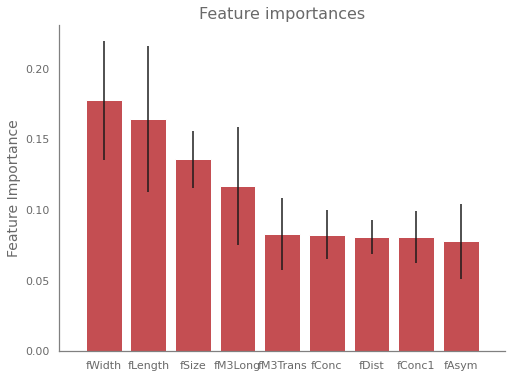

In [ ]:
importances = forest_def.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_def.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
ordered_feat=[]
print("Feature ranking:")

for f in range(X_train.shape[1]):
  ordered_feat.append(feat_names[indices[f]])
  print("%d. feature %s (%f)" % (f + 1, feat_names[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
fig, ax=plt.subplots(figsize=(8,6))
ax.set_title("Feature importances")
ax.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
ax.set_xticks(np.arange(len(ordered_feat)))
ax.set_xticklabels(ordered_feat)
ax.set_xlim([-1, X_train.shape[1]])
ax.set_ylabel("Feature Importance")
plt.show()

In order to perform a better separation we can combine the informations drawn from gammaness' distributions and the ones drawn from fAlpha's distributions. 

The plots show that gamma-ray events peak at low values of alpha and at high values (near 1) of gammaness.

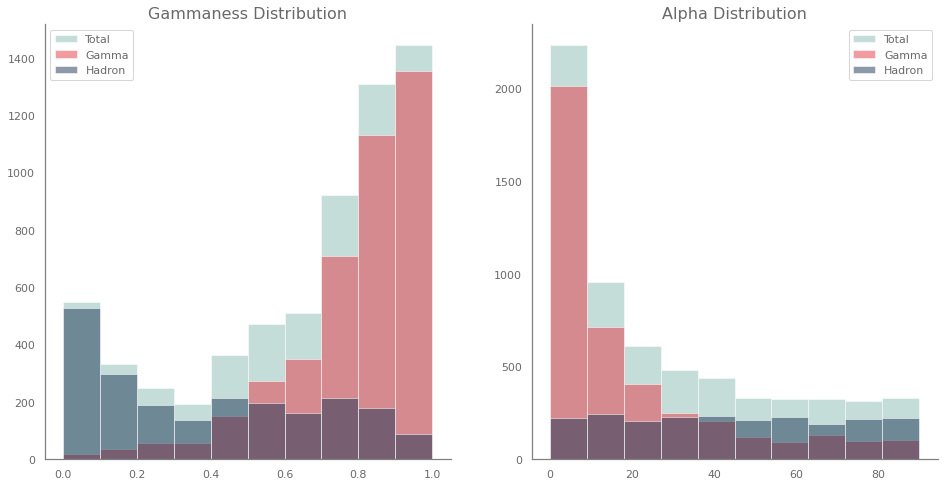

In [ ]:
fig, (ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(16,8))

ax1.hist(y_pred, label="Total", alpha=0.5, color=BR41_LightBlue)
ax1.hist(gammaness_gamma,label="Gamma", alpha=0.5, color=BR41_Red)
ax1.hist(gammaness_hadron, label="Hadron", alpha=0.5, color=BR41_DarkBlue)
ax1.set_title("Gammaness Distribution")
ax1.legend(loc='upper left')
ax2.hist(X_alpha_valid,label="Total", alpha=0.5,color=BR41_LightBlue)
ax2.hist(alpha_gamma, label="Gamma", alpha=0.5,color=BR41_Red)
ax2.hist(alpha_hadron,label="Hadron", alpha=0.5, color=BR41_DarkBlue)
ax2.set_title("Alpha Distribution")
ax2.legend(loc='upper right')
plt.show()


# Maximization of the quality factor

To evaluate the minimum signal that the MAGIC telescope is able to detect, we have to find the cuts in gammaness and alpha that maximize the quality factor $Q$. It is defined as the TPR over the square root of FPR, $Q=\frac{TPR}{\sqrt{FPR}}$, and gives a quantitative measure of the separation power. We look for the highest value of $Q$ with the costraint of having detected at least 10 real gammas and of having a number of event labelled as gamma at least the 5% of the number of events labelled as hadron.

In [ ]:
#Q-factor cuts

def Q (val):
  return val[0]/np.sqrt(val[1])


gammaness_th=np.linspace(0.1,1,100)
alpha_th=np.linspace(0, 30,100)[::-1]
Q_list=[]

Q_def=0
a_def, g_def, TP_def, FP_def=0,0,0,0

for g,a in [(g,a) for g in gammaness_th for a in alpha_th]:
  y_w=y_pred.copy()
  y_w[np.all([y_w>=g, X_alpha_valid<=a], axis=0)]=1
  y_w[np.any([y_w<g, X_alpha_valid>a], axis=0)]=0
  TP, FP=0,0
  for yp,yt in zip(y_w, Y_valid):
    if yp==1:
      if yt==1:
        TP+=1
      elif yt==0:
        FP+=1
  PPV=TP+FP
  NPV=len(y_w)-PPV
  if FP!=0 and TP>=10 and PPV>0.05*NPV:
    Q_new=Q([TP/P, FP/N])
    Q_list.append(Q_new)
    if Q_new>Q_def:
      Q_def=Q_new
      TP_def=TP
      FP_def=FP
      a_def=a
      g_def=g
  else: Q_list.append(float('nan'))
  
print("Alpha cut: {:.2f}".format(a_def), "\nGammaness cut: {:.2f}".format(g_def),
      "\nMaximum quality factor: {:.2f}".format(Q_def),"\nTP:", TP_def, 
      "\tFP:", FP_def, "\tP:", P, "\tN:", N)

Alpha cut: 7.27 
Gammaness cut: 0.93 
Maximum quality factor: 6.40 
TP: 564 	FP: 1 	P: 4135 	N: 2205


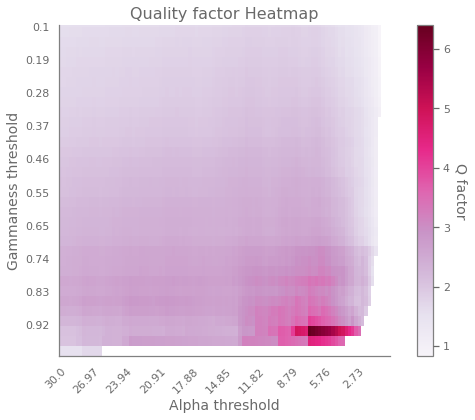

Alpha cut: 7.27 
Gammaness cut: 0.93 
Maximum quality factor: 6.40


In [ ]:
fig,ax_heat = plt.subplots(figsize=(8,6))


Qlist = np.array(Q_list)
Q_matrix =Qlist.reshape(len(gammaness_th),len(alpha_th))


im_Q = ax_heat.imshow(Q_matrix, vmin=0.83, cmap='PuRd')
cbar = ax_heat.figure.colorbar(im_Q, ax=ax_heat, cmap='Reds')
cbar.ax.set_ylabel("Q factor", rotation=-90, va="bottom")

lab_alp, lab_gamm=[],[]
for i in range(0,100,10):
  lab_alp.append(round(alpha_th[i],2))
  lab_gamm.append(round(gammaness_th[i],2))
  
ax_heat.set_xticks([0,10,20,30,40,50,60,70,80,90])
ax_heat.set_yticks([0,10,20,30,40,50,60,70,80,90])
ax_heat.set_xticklabels(lab_alp)
ax_heat.set_yticklabels(lab_gamm)

plt.setp(ax_heat.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


ax_heat.set_title("Quality factor Heatmap")
ax_heat.set_xlabel("Alpha threshold")
ax_heat.set_ylabel("Gammaness threshold")
fig.tight_layout()
plt.show()

print("Alpha cut: {:.2f}".format(a_def), "\nGammaness cut: {:.2f}".format(g_def),
      "\nMaximum quality factor: {:.2f}".format(Q_def))


The cuts found are finally applied to the test set.

In [ ]:
#Computation on the test set
y_pr_test=forest_def.predict_proba(X_test)[:,1]

TPR, FPR=[],[]
P_test=int(Y_test.sum())
N_test=int(X_test.shape[0]-P)

y_w = y_pr_test.copy()
y_w[np.all([y_w>=g_def, X_alpha_test<=a_def], axis=0)]=1
y_w[np.any([y_w<g_def, X_alpha_test>a_def], axis=0)]=0
TP, FP=0,0
for yp,yt in zip(y_w, Y_test):
  if yp==1:
    if yt==1:
      TP+=1
    elif yt==0:
      FP+=1
PPV=TP+FP
NPV=len(y_w)-PPV
Q_test1=Q([TP/P_test, FP/N_test])

print("\nQuality factor: {:.2f}".format(Q_test1),"\nTP:", TP, "\tFP:", FP, "\tP:", P_test)


Quality factor: 3.17 
TP: 551 	FP: 4 	P: 4086


The results of the maximization of Q over the validation set and those obtained applying alpha and gammaness cuts are displayed in a single table below. Thanks to the gammaness vs fAlpha graphs, it is possible to compare visually the number of events correctly guessed as signals and the wrong guessed ones with the the real signal events.

VALIDATION SET TEST SET
Maximum Q                     6.40     3.17
Gammaness cut value           0.93        /
Alpha cut value               7.27        /
Number of TP events            564      551
Number of FP events              1        4

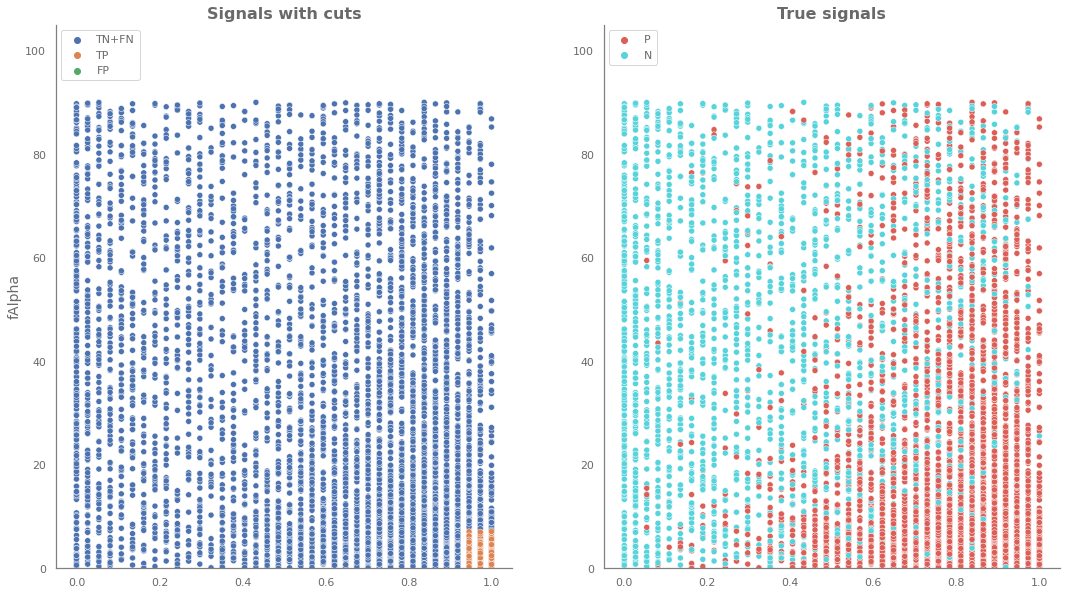

In [ ]:
y1_w=y_pr_test.copy()
y1_w[np.all([y1_w>=g_def, X_alpha_test<=a_def], axis=0)]=1
y1_w[np.any([y1_w<g_def, X_alpha_test>a_def], axis=0)]=0

NTP1, NFP1=0,0

for i in range(len(y_pr_test)):
    if y1_w[i]==1:
        if Y_test[i]==1:
            NTP1+=1
        elif Y_test[i]==0:
            y1_w[i]=2
            NFP1+=1
y1_w=y1_w.astype(str)
y1_w[y1_w=='1.0']='TP'
y1_w[y1_w=='2.0']='FP'
y1_w[y1_w=='0.0']='TN+FN'

y_str=Y_test.copy()
y_str=y_str.astype(str)
y_str[y_str=='0.0']='N'
y_str[y_str=='1.0']='P'

res_df=pd.DataFrame(data=[['{:.2f}'.format(Q_def),'{:.2f}'.format(Q_test1)],
                          ['{:.2f}'.format(g_def),'/'],
                          ['{:.2f}'.format(a_def),'/'],
                          [TP_def,TP],[FP_def,FP]], columns=('VALIDATION SET','TEST SET'), 
                    index=('Maximum Q', 'Gammaness cut value','Alpha cut value', 'Number of TP events', 'Number of FP events'))
display(res_df)
print('\n\n')

fip, (g1,g2)= plt.subplots(nrows=1,ncols=2, figsize=(18,10))

sns.scatterplot(ax=g1, x=y_pr_test, y=X_alpha_test, hue=y1_w, palette='deep')
g1.set_title('Signals with cuts', fontweight='bold')
g1.legend(loc='upper left')
g1.set_ylabel('fAlpha')
g1.set_ybound(0,105)

sns.scatterplot(ax=g2, x=y_pr_test, y=X_alpha_test, hue=y_str, palette='hls')
g2.set_title('True signals', fontweight='bold')
g2.legend(loc='upper left')
g2.set_ybound(0,105)

fip.show()


It is evident that the number of events we are able to correct classify as signals with this method is really small compared to the number of real signals. The reason is that in this task we are mainly focused on obtaining as few false positive events as possible, in order to not base our research on data that doesn't correspond to the physical phenomenon of study.

# Estimation of the observation time

In this section we compute the expected observation time of our test set as if it were collected observing the Crab Nebula.

We assume that the telescope has a collection area of 10$^9$ cm$^2$ and that we are observing gamma rays between 50 GeV and 50 TeV.

We consider the different spectrum models presented in HEGRA collaboration [2] and MAGIC [3]: a simple power law function, a power law with an exponential cutoff and two power low function with a logathmic correction on the exponent, fitted on different experimental measures (not on Monte Carlo data as in our case).

Every spectrum is a function:
$\frac{dN}{dE}=f(E)$

Since
$N = \frac{n_\gamma}{S \cdot \Delta t}$, with $n_\gamma$ = number of observed gammas, $S$=collection area and $\Delta t$=observation time, it is possible to compute the expected observation time as:

$\Delta t=\frac{n_\gamma}{S \cdot I}$

With $I$ the integral: 

$\int_{0.05 TeV}^{50 TeV} f(E) dE$ to be computed for every model.

In [ ]:
#constants
S=10**9
n_gamma=PPV
k=20
samples=(2**k)+1
E=np.linspace(start=0.05,stop=50,num=samples,endpoint=True)
dE=E[1]-E[0]

We start computing the collection time assuming the two models presented by HEGRA collaboration:

**simple power law presented in HEGRA** [2]:

$\frac{dN}{dE}=f_{0_{HE}} \cdot (\frac{E}{E_0})^{-\alpha_{HE}}$

where: 

$f_{0_{HE}}=2.79 \cdot 10^{-11} m^{-2} s^{-1} TeV^{-1}$

$\alpha_{HE}=2.59$

$E_0=1.0 TeV$

In this case $I$ is analytically computable: 

$\int f_0 \cdot (\frac{E}{E_0})^{-\alpha} dE = \frac{E_0^\alpha \cdot f_0}{\alpha-1} \cdot E^{-\alpha+1} $

In [ ]:
#computation of the collection time assuming HEGRA spectrum of Crab Nebula (simple power law)

f0_h_e=2.79*10**(-11)
alpha_h_e=2.59
e0=1.

def dN_HEGRA_e(x,e0,alpha):
    return (x/e0)**-alpha

analytical_intgr=((e0**alpha_h_e)*f0_h_e/(-alpha_h_e+1))*((50**(-alpha_h_e+1))-(0.05**(-alpha_h_e+1)))

ctime_HEGRA_exp=n_gamma/(S*analytical_intgr)#s

print('HEGRA collection time: {:.2f} min'.format(ctime_HEGRA_exp/60))

HEGRA collection time: 4.50 min


**Power law with the logarithmic correction on the exponent presented in HEGRA** [2]:

$\frac{dN}{dE}=f_{0_{HE}} \cdot (\frac{E}{E_0})^{-\alpha_{HE}+\beta_{HE} log(\frac{E}{E_0})}$

where: 

$f_{0_{HE}}=2.67 \cdot 10^{-11} m^{-2} s^{-1} TeV^{-1}$

$\alpha_{HE}=2.47$

$\beta_{HE}=-0.11 TeV$

$E_0=1.0 TeV$

In this case $I$ is: 

$I = \int_{0.05TeV}^{50TeV} f_{0_{HE}} \cdot (\frac{E}{E_0})^{-\alpha_{HE}+\beta_{HE} log(\frac{E}{E_0})}$

In [ ]:
#computation of the collection time assuming HEGRA spectrum of Crab Nebula (log correction)

f0_h_l=2.67*10**-11
e0=1.
alpha_h_l=2.47
beta_h_l=-0.11

def dN_l(x,e0,alpha,beta):
    return np.power(x/e0,-alpha+beta*np.log(x/e0))

intgr_HEGRA_l=intgr.romb(dN_l(E,e0,alpha_h_l,beta_h_l),dx=dE)

ctime_HEGRA_l=n_gamma/(S*f0_h_l*intgr_HEGRA_l)#s

print('HEGRA collection time: {:.2f} min'.format(ctime_HEGRA_l/60))

HEGRA collection time: 11.39 min


**Power law with the exponential cutoff presented in MAGIC** [2]:

$\frac{dN}{dE}=f_{0_{MG}} \cdot (\frac{E}{E_0})^{-\alpha_{MG}} \cdot (e)^{-\frac{E}{E_C}}$

where: 

$f_{0_{MG}}=3.80 \cdot 10^{-11} m^{-2} s^{-1} TeV^{-1}$

$\alpha_{MG}=2.21$

$E_0=1.0 TeV$

$E_C=6.0 TeV$

In this case $I$ is: 

$I = \int_{0.05TeV}^{50TeV} f_{0_{MG}} \cdot (\frac{E}{E_0})^{-\alpha_{MG}} \cdot (e)^{-\frac{E}{E_C}} $

In [ ]:
#computation of the collection time assuming MAGIC spectrum of Crab Nebula (cutoff power law)

f0_m_e=3.8*10**(-11)
ec_m_e=6.
e0=1.
alpha_m_e=2.21

def dN_MAGIC_e(x,e0,alpha,ec):
    return (x/e0)**(-alpha_m_e)*np.exp(-x/ec)

intgr_MAGIC_e=intgr.romb(dN_MAGIC_e(E,e0,alpha_m_e,ec_m_e),dx=dE)

ctime_MAGIC_e=n_gamma/(S*f0_m_e*intgr_MAGIC_e)#s

print('MAGIC collection time: {:.2f} min'.format(ctime_MAGIC_e/60))

MAGIC collection time: 8.10 min


**Power law with the logarithmic correction on the exponent presented in MAGIC** [2]:

$\frac{dN}{dE}=f_{0_{MG}} \cdot (\frac{E}{E_0})^{-\alpha_{MG}+\beta log(\frac{E}{E_0})}$

where: 

$f_{0_{MG}}=3.23 \cdot 10^{-11} m^{-2} s^{-1} TeV^{-1}$

$\alpha_{MG}=2.47$

$\beta = -0.24$

$E_0=1.0 TeV$


In this case $I$ is: 

$I = \int_{0.05TeV}^{50TeV} f_{0_{MG}} \cdot (\frac{E}{E_0})^{-\alpha_{MG}+\beta log(\frac{E}{E_0})}$

In [ ]:
#computation of the collection time assuming MAGIC spectrum of Crab Nebula (log correction)

f0_m_l=3.23*10**-11
e0=1.
alpha_m_l=2.47
beta_m_l=-0.24

intgr_MAGIC_l=intgr.romb(dN_l(E,e0,alpha_m_l,beta_m_l),dx=dE)

ctime_MAGIC_l=n_gamma/(S*f0_m_l*intgr_MAGIC_l)#s

print('MAGIC collection time: {:.2f} min'.format(ctime_MAGIC_l/60))


MAGIC collection time: 17.31 min


In [ ]:
print('HEGRA collection time from power low: {:.2f} min' .format(ctime_HEGRA_exp/60))
print('MAGIC collection time from exponential cutoff: {:.2f} min' .format(ctime_MAGIC_e/60))
print('HEGRA collection time from log-corrected power law: {:.2f} min' .format(ctime_HEGRA_l/60))
print('MAGIC collection time from log-corrected power law: {:.2f} min'.format(ctime_MAGIC_l/60))

output_file('Energy spectra')

x = np.linspace(start=0.05,stop=50,num=1000)
x1 = np.linspace(start=0.05,stop=0.5,num=1000)
y_he_exp = (10**8)*f0_h_e*dN_HEGRA_e(x,e0,alpha_h_e)
y_mg_exp = (10**8)*f0_m_e*dN_MAGIC_e(x,e0,alpha_m_e,ec_m_e)
y_he_log = (10**8)*f0_h_l*dN_l(x,e0,alpha_h_l,beta_h_l)
y_mg_log = (10**8)*f0_m_l*dN_l(x,e0,alpha_m_l,beta_m_l)


fig_ES = figure(background_fill_color='white',
             plot_height=500,
             plot_width=600,
             x_axis_label='E [TeV]',
             x_axis_location='below',
             x_axis_type='log',
             y_axis_label='dN/dE [(10^{8})*cm^(-2)/(s*TeV)]',
             y_axis_location='left',
             y_axis_type='log',
             title='Energy Spectra - click on legend to hide curve',
             title_location='above',
             toolbar_location='below'
             )
fig_ES.axis.axis_line_width = 1
fig_ES.axis.axis_line_color = "dimgray"
fig_ES.grid.grid_line_color = "gainsboro"

fig_ES.line(x=x, y=y_he_exp, line_width=2, line_dash='dashed', color='#E24A33', legend_label='HEGRA-pow', muted_alpha=0.1)
fig_ES.line(x=x, y=y_mg_exp, line_width=2, line_dash='dashed',color='#348ABD', legend_label='MAGIC-pow cut', muted_alpha=0.1)
fig_ES.line(x=x, y=y_he_log, line_width=2, line_dash='dashed',color='#FBC15E', legend_label='HEGRA-log', muted_alpha=0.1)
fig_ES.line(x=x, y=y_mg_log, line_width=2, line_dash='dashed',color='#8EBA42', legend_label='MAGIC-log', muted_alpha=0.1)

fig_ES.legend.label_text_font = "calibri"
fig_ES.axis.axis_label_text_font="calibri"

fig_ES.legend.click_policy = 'mute'

show(fig_ES)

HEGRA collection time from power low: 4.50 min
MAGIC collection time from exponential cutoff: 8.10 min
HEGRA collection time from log-corrected power law: 11.39 min
MAGIC collection time from log-corrected power law: 17.31 min


As stated in *Aharonian, F. et al. The Energy Spectrum of TeV Gamma-Rays from the Crab Nebula as measured by the HEGRA system of imaging air Cherenkov telescopes Astrophys. J. 539 (2000) 317-324*, the simple power law function fits data from 1 to 20 TeV, so just a cut in our energy range. The log-corrected power law presented in the HEGRA paper was an attempt of extension of the function predicting the spectrum to lower energies, exploiting the inverse Compton modelling, which predicts a steepening in the energy spectra. Even though, in the paper they discussed that the results of the two models were compatible in the range 0.5-20 TeV, so there was no reason to choose the log-corrected model. As we see from our predicted collection times, instead in the energies below these two models are fairly different, and the consequences of the steepening are visible.

Instead, in *Aleksic, J. et al. Measurement of the Crab Nebula spectrum over three decades in energy with the MAGIC telescopes Journal of High Energy Astrophysics, 5–6 (2015) 30-38* are considered equivalently two models: an exponential cutoff and a log-corrected power. In this work, thanks to the data at disposal, it was possible to fit a wider range of the spectrum, from 50 GeV to 30 TeV, much closer to our range of interest. The results suggested that the log-corrected power law was more in accord with the data, the exponential cutoff was a too simplicistic model both for the high energy data and for the low energy ones, so it is a good predictor just in a thin range of medium energy.

In conclusion, we take the MAGIC log-power law as the true predictor for our range of interest, and subsequentially a collecting time of abount 18 minutes. The collection times corresponding to other possible spectral distributions are fairly smaller, due to the fact that those models have bigger undelying areas in the low energy range. In any case our estimate is far to be a precise one and can't be compared to the collection times presented in articles: this is due to the fact that our dataset is Monte Carlo generated and the assumptions on the collection area and the source of the gamma rays are arbitrary. 


# Bibliography

[1] Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004). Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. Nucl.Instr.Meth. A, 516, pp. 511-528.

[2] Aharonian, F. et al. The Energy Spectrum of TeV Gamma-Rays from the Crab Nebula as measured by the HEGRA system of imaging air Cherenkov telescopes Astrophys. J. 539 (2000) 317-324

[3] Aleksic, J. et al. Measurement of the Crab Nebula spectrum over three decades in energy with the MAGIC telescopes Journal of High Energy Astrophysics, 5–6 (2015) 30-38.